<a href="https://colab.research.google.com/github/JJang-likit/GoingDeeper_Aiffel/blob/main/GoingDeeper11_OCR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GoingDeeper11_OCR = Text detection + Text recognition

OCR(Optical Character Recognition)은 크게 문자의 영역을 검출하는 Text detection과 검출된 영역의 문자를 인식하는 Text recognition으로 구분할 수 있다. 이 두 과정을 거쳐 이미지 속 문자를 읽게 된다.

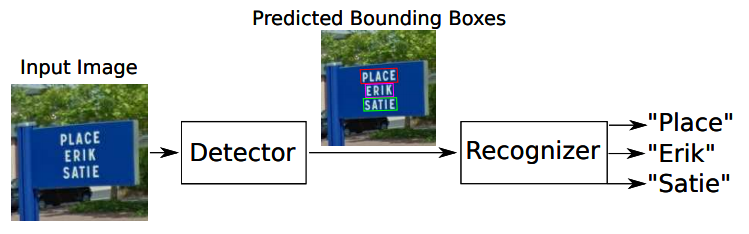

1. Text detection = 그동안 다루어왔던 일반적인 Object detection 태스크를 문자 찾아내기로 확장한 버전으로 생각할 수 있다. 하지만 Text detection은 Segmentation 기법도 동원되며 문자가 가지는 독특한 특성을 고려한 형태로 발전한다.

2. Text recognition = 검출된 영역의 문자가 무엇인지를 인식해내는 과정으로 잘 분리된 텍스트 이미지 뿐만 아니라 그렇지 않은 데이터들도 많다. 그렇기 때문에 OCR 분야에서 사용하는 독특한 모델 구조를 다룰 수 있어야 한다. 

## Text detection

- 텍스트의 위치를 찾는 Text detection의 방법은 문자의 특성을 생각해야 한다. 문자는 몇 개가 모여서 단어 혹은 문장을 이루고 있어서 이미지 내에서 문자를 검출해내기 위해서는 검출하기 위한 최소 단위를 정해야 한다.
- **단어 단위**의 탐지는 앞서 배운 object detection의 Regression 기반의 Detection 방법이다. Anchor를 정의하고 단어의 유무와 Bounding box의 크기를 추정해서 단어를 찾아낸다.
- **글자 단위**의 방식은 Bounding box regression을 사용하는 대신 글자 영역을 Segmentation 하는 방법으로 접근한다.

### Regression - TextBoxes

- TextBoxes는 2017년에 공개된 논문으로 TextBoxes 이전에는 글자 단위로 인식한 후 결합하는 방식을 취해 왔지만 위 논문에서는 딥러닝 기반의 detection을 이용하여 단어 단위로 인식하기 시작했다.
- 네트워크의 기본 구조는 SSD:single shot multibox detection을 활용하였다.

### Segmentation - PixelLink
- Segmentation을 사용하면 이미지 내의 영역을 class로 분리해낼 수 있다.
- 이 방법을 통해서 문자의 영역을 찾기 위해 적용하면 배경과 글자인 영역을 분리할 수 있다.
- 하지만 문자들은 매우 촘촘하게 배열되어 있기 때문에 글자 영역으로 찾아낸 뒤 이를 분리해내는 작업이나 연결하는 작업을 추가로 해주어야 한다.

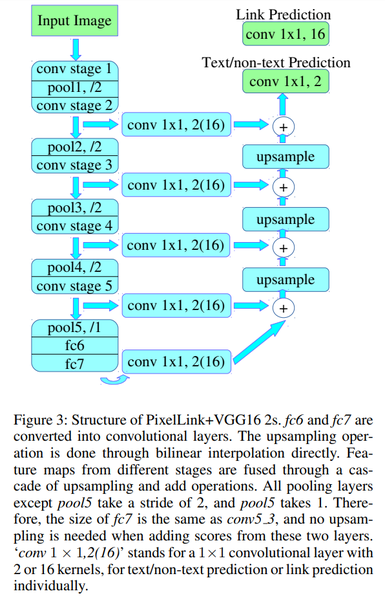



*   PixelLink
  - 전체적인 구조는 U-Net과 유사하지만 output으로 총 9가지의 정보를 얻는다.
  - PixelLink는 Text영역을 찾아내는 segmentation과 함께 글자가 어느 방향으로 연결되었는지를 같이 학습하여 Text 영역 간의 분리 및 연결을 할 수 있는 정보를 추가적으로 활용하고 있다.
  - 위 그림에서 녹색 부분이 input과 output을 의미하는데 output중 하나는 Text/non-test prediction을 위한 class segmentation map으로 해당 영역이 Text인지 non-Text인지 예측하는 예측값을 의미하는 2개의 커널을 가진다.
  - 나머지 8개는 글자의 Pixel을 중심으로 인접한 8개의 Pixel에 대한 연결 여부를 의미하는 16개의 커널로 이루어진 Link Prediction map이다.
  - conv1x1, 2(16) 형태의 레이어가 U-Net 구조로 연결되어 인접 Pixel간 연결 구조가 지속적으로 유지되도록 모델이 구조화되어 있다.
  - 이를 통해서 인접한 Pixel이 중심 Pixel과 단어 단위로 연결된 Pixel인지 아니면 분리된 Pixel인지 알 수 있으므로 문자 영역이 단어 단위로 분리된 Instance segmentation이 가능해진다.


### CRAFT(Character Region Awareness for Text Detection)

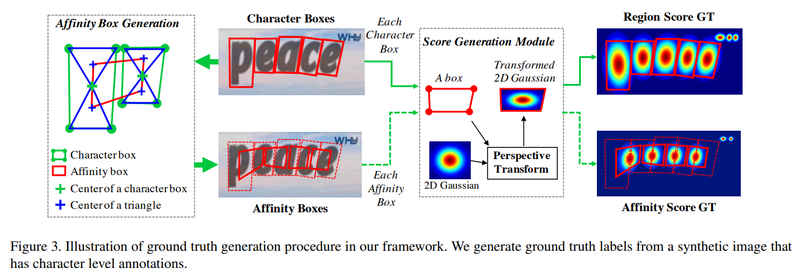

- CRAFT는 문자 단위로 문자의 위치를 찾아낸 뒤, 이를 연결하는 방식을 segmentation 기반으로 구현한 방법이다.
- 문자의 영역을 boundary로 명확히 구분하지 않고, 가우시안 분포를 따르는 원형의 score map을 만들어서 배치시키는 방법으로 문자의 영역을 학습한다.
- 문자 단위 라벨을 가진 데이터셋이 많지 않기 때문에 단어 단위의 정보만 있는 데이터셋에 대해 단어의 영역에 Inference를 한 후 얻어진 문자 단위의 위치를 다시 학습에 활용하는 Weakly supervised learning을 활용하였다.

### Pyramid Mask Text Detection

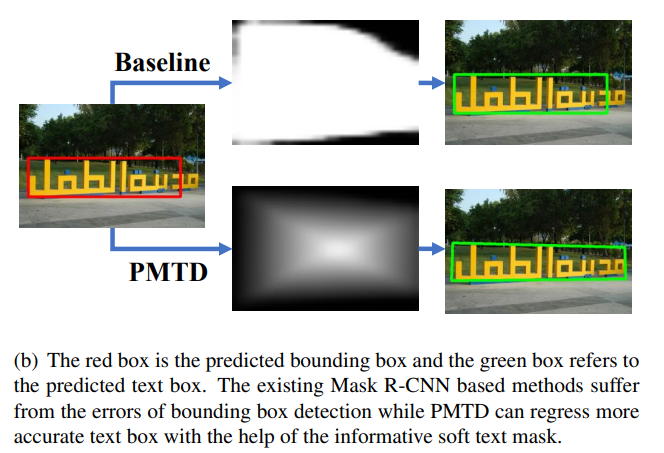

- PMTD는 Mask-RCNN의 구조를 활용하여 먼저 Text영역을 Region proposal network로 찾아낸다.
- 그 다음 Box head에서 더 정확하게 regression 및 classification을 하고 Mask head 에서 Instance의 segmentation을 하는 과정을 거친다.
- PMTD는 Mask 정보가 부정확한 경우를 반영하기 위해서 Soft-segmentation을 활용한다.
- 이전의 Mask-RCNN의 경우, 단어 영역이 Box head에 의해 빨간색으로 잡히면 위의 이미지의 baseline처럼 boundary를 모두 Text 영역으로 잡지만, PMTD는 단어의 사각형 배치 특성을 반영하여 피라미드 형태의 Score map을 활용합니다.
- 따라서 Pyramid 형상의 Mask를 가지게 되어서 Pyramid Mask Text detection이라는 이름이 붙었다.

## Text Recognition

### Unsegmented Data
- 분리에 드는 비용이 많이 들거나 어려워서 Segmentation 되어 있지 않은 데이터를 Unsegmented Data라고 한다.
- Unsegmented Data들이 가진 주요한 특징 중 하나는 segment되어 있지 않은 하위 데이터들끼리 시퀀스를 이루고 있다는 점이다.
- 그래서 연구자들이 생각해 낸 방법 중 하나는 CNN과 RNN을 같이 쓰는 방법이다. 이런 방법을 CRNN이라고 한다.



*   CRNN
  - 문자 이미지 정보를 추출하기 위해서는 Feature Extractor가 필요하다.
  - Feature Extractor로 사용되는 CNN기반의 VGG 또는 ResNet과 같은 네트워크로부터 문자의 정보를 가진 Feature를 얻어낼 수 있다.
  - 이렇게 추출된 Feature를 Map-To-Sequence를 통해 Sequence형태의 feature로 변환한 후, 다양한 길이의 Input을 처리할 수 있는 RNN으로 넣는다.
  - RNN이 Feature로부터 문자를 인식하기 위해서는 문자 영역처럼 넓은 정보가 필요하기 때문에 LSTM으로 구성한다.





*   CTC
 - CTC는 CRNN이 Unsegmented Data를 처리하기 위해 활용하는 방법이다.
 - 서로 다른 Length의 Sequence를 가질 때 이를 Align 없이 활용할 수 있다.
 - Label Encode에서 같은 문자를 구분하기 위한 Blank를 중복된 라벨 사이를 구분하기 위해 넣어준다.
 - 이후 Decode 후에 중복을 제거하고 인식할 문자가 아닌 값을 지워주면 결과를 얻을 수 있다.
 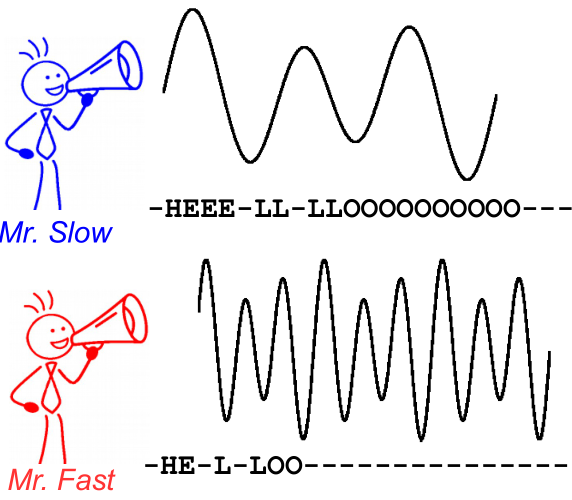





*   TPS(Thin Plate Spline)
 - 책이 아닌 거리의 글자를 읽을 때, OCR이 어려운 이유는 불규칙한 방향이나 휘어진 진행 방향 때문이다.
 - TPS를 적용하면 입력 이미지를  단어 영역에 맞게 변형시켜 인식이 잘 되도록 할 수 있다.
 - TPS는 control point를 정의하고 해당 point들이 특정 위치로 옮겨졌을 때 축 방향의 변화를 interpolation하여 모든 위치의 변화를 추정해낸다.
 - 이를 통해서 전체 이미지 pixel의 변화를 control point로 만들어낼 수 있다.
 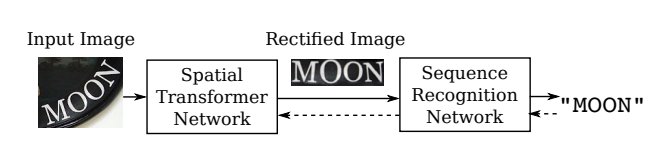
 - Spatial Transformer Network를 통해서 Control point가 얼마나 움직여야 예측하는 네트워크를 Recognition model 앞단에 붙여 입력 이미지를 정방향으로 맞춰준다.
 - TPS 연산은 미분 가능한 연산이기 때문에 Recognition model 앞단에 붙여서 학습이 바로 가능하다.
 - Spatial Transformer Network 관련 자료 : https://3months.tistory.com/197

